# 6. Analyze Relationship between Like or Dislike Ratio and Sentiment

# Table of contents
1. [Import libraries](#import_libraries)
2. [Load data](#load)
3. [Use Textblob library to get sentiment](#sentiment)
4. [Calculate correlation between like_rate, dislike_rate and comment_rate](#correlation)
5. [Creating correlation matrix](#correlation matrix)

### Import libraries <a name="import_libraries"></a>

In [1]:
import pandas as pd
from textblob import TextBlob
import numpy as np
import tqdm
from pathlib import Path
cwd = Path('.')
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [2]:
from collections import Counter
from scipy.stats import pearsonr
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

In [3]:
from random import seed
RANDOM = 42
seed(RANDOM)
np.random.seed(RANDOM)

### Load data <a name="load"></a>

In [4]:
videos_df = pd.read_csv(cwd/'output'/"videos.csv")

In [5]:
videos_df = videos_df.drop_duplicates(subset='video_id')
videos_df = videos_df.dropna()

In [6]:
videos_df = videos_df[['video_id', 'like_rate', 'dislike_rate', 'comment_rate']]

In [8]:
comments_df = pd.read_csv(cwd/'output'/"comments.csv" , encoding="ISO-8859-1")

C:\Users\User\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
#Using Textblob library to calculate sentiments
def sentiment_calc(text):
    try:
        return TextBlob(text).sentiment.polarity
    except:
        return None

In [10]:
#function to change the continuous sentiment score to discrete
def pol2sent(pol):
    if pol<=-.5:
        return 0 #"Very negative"
    if pol>-.5 and pol<0:
        return 1 #"Negative"
    if pol == 0:
        return 2 #"Neutral"
    if pol > 0 and pol<0.5:
        return 3 #"Positive"
    if pol>=0.5:
        return 4 #"Very positive"

### Use Textblob library to get sentiment <a name="sentiment"></a>

In [11]:
#add one more column of [sentiment] to comments_df. Consist sentiment score
comments_df['sentiment'] = comments_df.apply(lambda row: sentiment_calc(row["comment_text"]), axis=1)

In [12]:
#check sentiment that value is null
comments_df['sentiment'].isnull().sum()

51

In [13]:
#only keep rows where sentiment is not null
comments_df = comments_df[pd.notnull(comments_df['sentiment'])]

In [14]:
comments_df['sentiment'].isnull().sum()

0

In [15]:
class Sentiment:
    def __init__(self):
        self.sentiment_scores = []
        self.sentiment_categories = []
        self.average_sentiment = None
        self.sentiment_categories_vector = None
    def add_sentiment_score(self, score):
        self.sentiment_scores.append(score)
    def add_sentiment_category(self, category):
        self.sentiment_categories.append(category)
    def set_average_sentiment(self):
        self.average_sentiment = sum(self.sentiment_scores)/len(self.sentiment_scores)
    def set_sentiment_categories_vector(self):
        self.sentiment_categories_vector = [Counter(self.sentiment_categories)[i] for i in [0, 1, 2, 3, 4]]
        self.sentiment_categories_vector = np.array(self.sentiment_categories_vector)/len(self.sentiment_categories)

In [16]:
video_id_sentiment = {} # video_id : sentiment_object
for _, row in comments_df.iterrows():
    video_id = row['video_id']
    sentiment = row['sentiment']
    sentiment_category = pol2sent(sentiment)
    if video_id not in video_id_sentiment:
        video_id_sentiment[video_id] = Sentiment()
    video_id_sentiment[video_id].add_sentiment_score(sentiment)
    video_id_sentiment[video_id].add_sentiment_category(sentiment_category)

In [17]:
for video_id, sentiment_object in video_id_sentiment.items():
    sentiment_object.set_average_sentiment()
    sentiment_object.set_sentiment_categories_vector()

In [18]:
video_id_ratio = {}
for _, row in videos_df.iterrows():
    video_id = row['video_id']
    like_rate = row['like_rate']
    dislike_rate = row['dislike_rate']
    comment_rate = row["comment_rate"]
    if video_id not in video_id_ratio:
        video_id_ratio[video_id] = {}
    video_id_ratio[video_id]['like_rate'] = like_rate
    video_id_ratio[video_id]['dislike_rate'] = dislike_rate
    video_id_ratio[video_id]['comment_rate'] = comment_rate

### Calculate correlation between like_rate, dislike_rate and comment_rate <a name="correlation"></a>

In [19]:
metrics = ['like_rate', 'dislike_rate', 'comment_rate']
for metric in metrics:
    X = []
    y = []
    for video_id, sentiment_object in video_id_sentiment.items():
        if video_id in video_id_ratio:
            X.append(sentiment_object.average_sentiment)
            y.append(video_id_ratio[video_id][metric])
    X = np.array(X).reshape(-1, 1)
    X = np.nan_to_num(X)
    y = np.array(y).reshape(-1, 1)
    scaler = MinMaxScaler()
    scaler.fit(y)
    y = scaler.transform(y)
    scaler = MinMaxScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    from scipy.stats import pearsonr
    print(f"The correlation between sentiment and {metric}: {pearsonr(X.reshape(-1), y.reshape(-1))[0]}")

The correlation between sentiment and like_rate: 0.3472276174623389
The correlation between sentiment and dislike_rate: -0.21289988245291747
The correlation between sentiment and comment_rate: -0.011427047673686417


### Create a correlation matrix <a name="correlation matrix"></a>

In [20]:
#create a video sentiment data frame with [polarity,video_id] and video_id index
Videosentiment = comments_df.groupby("video_id").mean()
Videosentiment['video_id'] = Videosentiment.index
Videosentiment.head()

,sentiment,video_id
video_id,,
--JinobXWPk,0.041247,--JinobXWPk
--y69Ui8xwM,0.170290,--y69Ui8xwM
-1fzGnFwz9M,0.142876,-1fzGnFwz9M
-2hRYEFiPSA,0.238438,-2hRYEFiPSA
-3AGlBYyLjo,-0.318750,-3AGlBYyLjo


In [21]:
#add one more column [sentiment] by merging USvideos and Videosentiment on video_id
videos_df=videos_df.merge(Videosentiment, on="video_id")

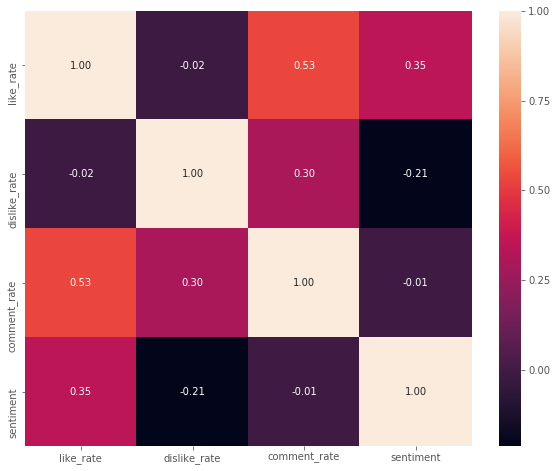

In [23]:
#make the correlation matrix
plt.figure(figsize = (10,8))
sns.heatmap(videos_df[['like_rate', 'dislike_rate', 'comment_rate','sentiment']].corr(), annot=True, fmt=".2f")
plt.show()